Plan:
- [x] Read the article
- [x] Repeat it here
    - [x] Fix translation
- [] Reread what was written
- [WONTFIX] Integrate article about two fish bites
- [] Do necessary refactoring if needed

<center>
    <p>
        <h1>Z-VALUE, Z-STATISTICS AND P-VALUE</h1>
        <h5>explained with an example</h5>
    </p>
</center>

In this notebook I try to understand what are $z$-value, $z$-statistics and $p$-value. 

In order to explain it in a more clear way an imaginary, yet close to reality example, is used. Throughout the year we ordered pizza and measured delivery time (that gives us the general population) and after this period our new neighbor decided to order pizza too, but his delivery times are too long (by his opinion). Our task is to understand what the probability of obtaining such delivery times.

This notebook is heavily based on this [article](https://habr.com/ru/post/557424/) (it's in russian) with some minor tweaks and additions.

# 1. Generate data

Import required libraries, set chart parameters for the whole notebook and set random seed.

In [1]:
from collections import namedtuple
from dataclasses import dataclass

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import ticker
from scipy import stats

In [2]:
matplotlib.rcParams["figure.figsize"] = 20, 7
plt.style.use("fivethirtyeight")
sns.set_style("whitegrid")

In [43]:
# this helps to get the same values no matter how many times cells are executed
RANDOM_STATE = 42

Imaginary situation: during the whole year we have been ordering pizza and decided that for each delivery we will measure how much time it took in minutes. So after the whole year (365 days) we've got this data:

In [54]:
pizza_delivery_norm_rv = stats.norm(loc=30, scale=5)
pizza_delivery_times = pizza_delivery_norm_rv.rvs(365, random_state=RANDOM_STATE).astype(int)
pizza_delivery_times[:50]

array([32, 29, 33, 37, 28, 28, 37, 33, 27, 32, 27, 27, 31, 20, 21, 27, 24,
       31, 25, 22, 37, 28, 30, 22, 27, 30, 24, 31, 26, 28, 26, 39, 29, 24,
       34, 23, 31, 20, 23, 30, 33, 30, 29, 28, 22, 26, 27, 35, 31, 21])

<div class="alert alert-block alert-info"><b>Small note about the data</b>: it might look strange that here we generated data from the normal distribution with some parameters and later on we spend some time on discovering from what type of distribution these values were obtained. Just imaging that we didn't generated this data ourself and don't even know at the moment what type of distribution it has 😉.</div>

Of course we want to take a look at the min, max, mean and std values.

In [55]:
print("Delivery time stats\n")
for func in ("min", "max", "mean", "std"):
    print(f"{func.title():4}: {getattr(pizza_delivery_times, func)():.2f}")

Delivery time stats

Min : 13.00
Max : 49.00
Mean: 29.52
Std : 4.77


As we can see pizza delivery time takes approximately 30 $\pm$ 5 minutes.

As a final step let's plot a histogram so we can see how the data is distributed:

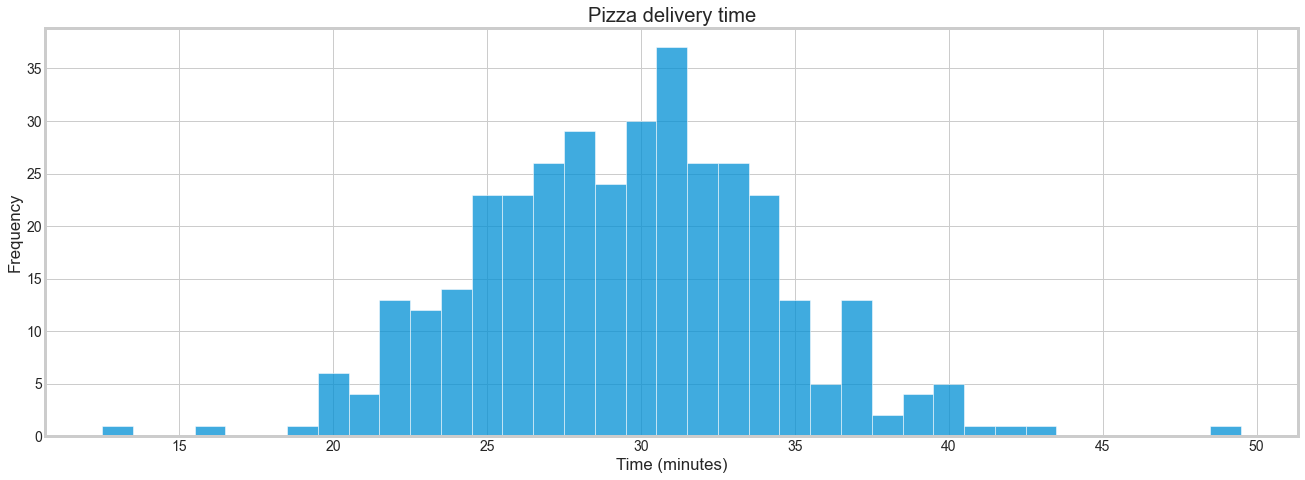

In [56]:
plt.title("Pizza delivery time")
plt.xlabel("Time (minutes)")
plt.ylabel("Frequency")
sns.histplot(pizza_delivery_times, discrete=True)

plt.show()

## 1.1. Determine type of distribution

Looking at this chart we can assume the the pizza delivery time has a normal distribution with parameters $\mu$=30 and $\sigma$=5. But why we so easily decided that the distribution is normal? Is it because the histogram looks quite similar to the probability function of normal distribution? If it is so then the bad news is that we can easily draw density distribution function of gamma, beta or even triangular distribution and find such parameters that they will fit our histogram as good as normal distribution:

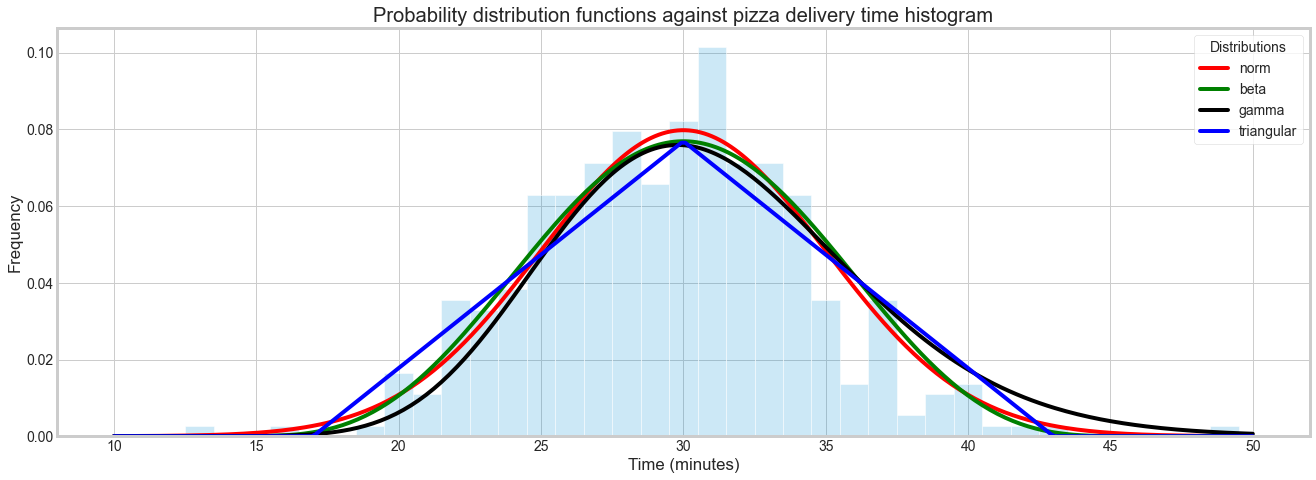

In [57]:
# create distributions
x = np.linspace(10, 50, 300)

norm_rv = stats.norm(loc=30, scale=5)
beta_rv = stats.beta(a=5, b=5, loc=14, scale=32)
gamma_rv = stats.gamma(a=20, loc=7, scale=1.2)
tri_rv = stats.triang(c=0.5, loc=17, scale=26)

# plot distributions
fig, ax = plt.subplots()

ax.set_title("Probability distribution functions against pizza delivery time histogram")
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Frequency")

sns.lineplot(ax=ax, x=x, y=norm_rv.pdf(x), color="r", label="norm")
sns.lineplot(ax=ax, x=x, y=beta_rv.pdf(x), color="g", label="beta")
sns.lineplot(ax=ax, x=x, y=gamma_rv.pdf(x), color="k", label="gamma")
sns.lineplot(ax=ax, x=x, y=tri_rv.pdf(x), color="b", label="triangular")
sns.histplot(ax=ax, x=pizza_delivery_times, discrete=True, stat="probability", alpha=0.2)

ax.get_legend().set_title("Distributions")

plt.show()

#### _So are we sure that this is a normal distribution_?

Pizza is delivered by a person, and the delivery process itself is accompanied by many random events that can happen on its way:
- At the intersection might have to wait two minutes till the traffic light turns green.
- Delivery guy hit his foot and, because of his injury, walked longer than usual.
- A black cat ran across the road so our delivery guy had to choose a longer route.
- Etc.

We can come up with a lot of such events but what is important for us is that these events can be described by such variables, the values of which are equally probable, i.e. have uniform distribution. 

As an example, we can come up with a variable $X_{1}$ that will describe the waiting time of a traffic light turn green at an intersection. If this time ranges between 0 and 4 minutes, then today this time can be:

In [44]:
uniform_rv = stats.uniform(loc=0, scale=4)
uniform_rv.rvs(size=1, random_state=RANDOM_STATE)

array([1.49816048])

Tomorrow, the day after tomorrow and the day after-after tomorrow, this time can be equal to:

In [131]:
uniform_rv.rvs(size=3, random_state=RANDOM_STATE)

array([1.49816048, 3.80285723, 2.92797577])

What if we have 15 such variables and the value of each of them contributes to the total delivery time because such events can add up: 

$$ Y = X_{1} + X_{2} + ... + X_{15} = \sum_{i=1}^{15}X_{i} $$

where $Y$ is total delivery time and it also a random variable.


if values for each of the variable $X_{1}, X_{2}, ... ,X_{15}$ are evenly distributed, then how about their sum, the variable $Y$?

In order to find out let's generate 10k such sums and take a look at the histogram:

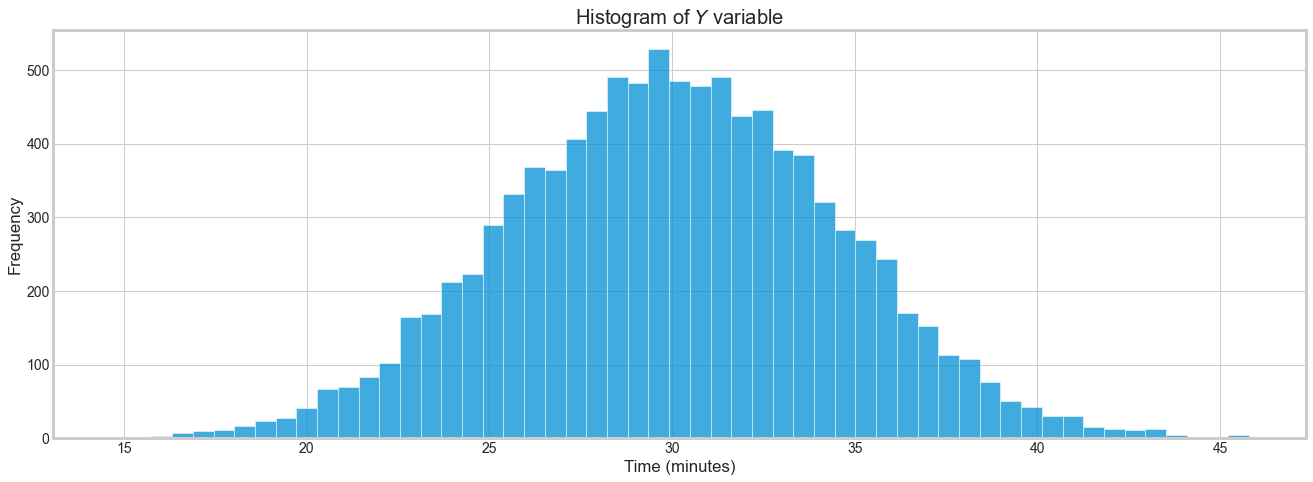

In [45]:
np.random.seed(RANDOM_STATE)
Y_samples = [uniform_rv.rvs(size=15).sum() for _ in range(10_000)]

plt.title("Histogram of $Y$ variable")
plt.xlabel("Time (minutes)")
plt.ylabel("Frequency")
sns.histplot(x=Y_samples)

plt.show()

Does this chart remind you the same bell of the normal distribution (normal distribution is visually similar to the bell)? If it is so, then you've just understood the meaning of the central limit theorem: the distribution of the sum of random variables tends to a normal distribution as the number of terms in this sum increases.

Of course, the pizza delivery example is not entirely correct for demonstrating central limit theorem, as all the events that we came up are conditional:
- At the intersection had to wait two minutes till the traffic light turns green; but we wil have to wait only if we approached the traffic light when it was red.
- Delivery gy hit his foot and, because of it, walked slower than usual; but with some probability he might not hit his foot.
- A black cat ran across the road and the other way took longer; there is non-zero probability that the delivery guy isn't afraid of black cat crossing his way.

The fact that each of the variable $X_{1}, X_{2}, ... ,X_{15}$ is conditional means that they can be included in the sum in a variety of combinations. For example, today the delivery time is a combination of:

$$ Y = X_{3} + X_{5} + X_{7} + X_{11} $$ 

And tomorrow it might be:

$$ Y = X_{1} + X_{3} + X_{9} + X_{10} + X_{13} + X_{15}$$ 

Does it mean that $Y$ random variable is distributed normally? Well, considering that the sum of normally distributed variables also has a normal distribution, we can give an affirmative answer. That is why, the same moment we looked at the distribution of 365 deliveries, we decided that we had normal distribution, even though it doesn't look like a perfect bell.

## 1.2. Central limit theorem

Central limit theorem says: no matter how the values from general population are distributed the distribution of sample mean values will be closer to a normal distribution the larger the sample size is.

In order to prove that let's generate 1k samples from uniform, exponential and Laplace distributions and then plot kde charts of the distributions of sample means of different size:

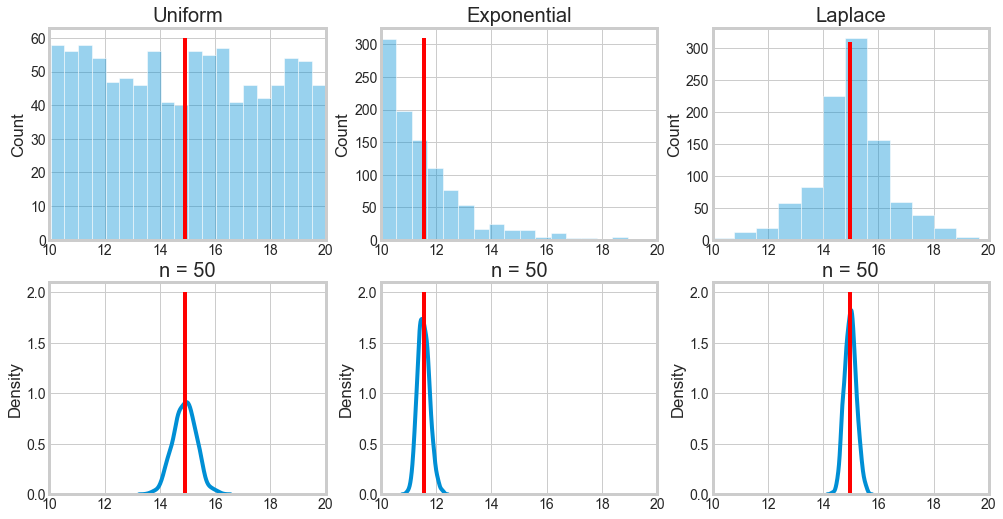

In [134]:
# TODO: fix seed (maybe)
import matplotlib.animation as animation

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))

unif_rv = stats.uniform(loc=10, scale=10)
exp_rv = stats.expon(loc=10, scale=1.5)
lapl_rv = stats.laplace(loc=15)

np.random.seed(42)
unif_data = unif_rv.rvs(size=1000)
exp_data = exp_rv.rvs(size=1000)
lapl_data = lapl_rv.rvs(size=1000)

title = ["Uniform", "Exponential", "Laplace"]
data = [unif_data, exp_data, lapl_data]
y_max = [60, 310, 310]
n = [3, 10, 30, 50]

for i, ax in enumerate(axes[0]):
    sns.histplot(data[i], bins=20, alpha=0.4, ax=ax)
    ax.vlines(data[i].mean(), 0, y_max[i], color="r")
    ax.set_xlim(10, 20)
    ax.set_title(title[i])


def animate(i):
    for ax in axes[1]:
        ax.clear()
    for j in range(3):
        rand_idx = np.random.randint(0, 1000, size=(1000, n[i]))
        means = data[j][rand_idx].mean(axis=1)
        sns.kdeplot(means, ax=axes[1][j])
        axes[1][j].vlines(means.mean(), 0, 2, color="r")
        axes[1][j].set_xlim(10, 20)
        axes[1][j].set_ylim(0, 2.1)
        axes[1][j].set_title("n = " + str(n[i]))
    fig.set_figwidth(15)
    fig.set_figheight(8)
    return axes[1][0], axes[1][1], axes[1][2]


dist_animation = animation.FuncAnimation(fig, animate, frames=np.arange(4), interval=200, repeat=False)
# dist_animation.save("dist_means.gif", writer="imagemagick", fps=1);
dist_animation.save("dist_means.gif", writer="pillow", fps=1);

![gif](dist_means.gif)

## 1.3. More about normal distribution

The [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) is a distribution that is given by a [Gaussian function](https://en.wikipedia.org/wiki/Gaussian_function) and in itself a density function, it is symmetric and unimodal. And the most important thing for us is that the deviations of values from the mean are not only equally probable, but also obey a well-known probability law. Let's look at this distribution and understand clearly what is all means:

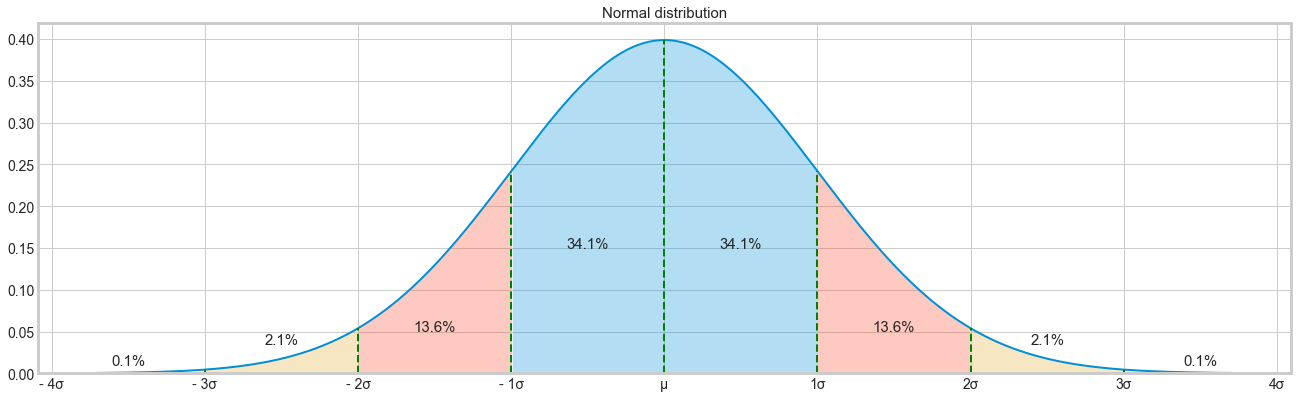

In [243]:
# TODO: refactor this
_, ax = plt.subplots(figsize=(20, 6))
# get normal distribution func
norm_rv = stats.norm(loc=0, scale=1)

# generate a thousand of values in boundaries of instantiated normal distribution
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 1_000)
# lw = line width
ax.plot(x, norm_rv.pdf(x), lw=2)

# middle of the distribution (loc)
ax.vlines(0, 0, norm_rv.pdf(0), color="g", lw=2, linestyles="dashed")

# +- one sigma
ax.vlines([-1, 1], 0, norm_rv.pdf(1), color="g", lw=2, linestyles="dashed")
ax.fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where=(x > -1) & (x < 1))
ax.text(0.5, 0.15, "34.1%", size=15, ha="center")
ax.text(-0.5, 0.15, "34.1%", size=15, ha="center")

# +- two sigmas
ax.vlines([-2, 2], 0, norm_rv.pdf(2), color="g", lw=2, linestyles="dashed")
ax.fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where=(x > -2) & (x < -1) | (x > 1) & (x < 2))
ax.text(1.5, 0.05, "13.6%", size=15, ha="center")
ax.text(-1.5, 0.05, "13.6%", size=15, ha="center")

# +- three sigmas
ax.vlines([-3, 3], 0, norm_rv.pdf(3), color="g", lw=2, linestyles="dashed")
ax.fill_between(x, norm_rv.pdf(x), np.zeros(len(x)), alpha=0.3, where=(x > -3) & (x < -2) | (x > 2) & (x < 3))
ax.text(2.5, 0.035, "2.1%", size=15, ha="center")
ax.text(-2.5, 0.035, "2.1%", size=15, ha="center")

# +- four sigmas
ax.text(3.5, 0.01, "0.1%", size=15, ha="center")
ax.text(-3.5, 0.01, "0.1%", size=15, ha="center")

# set x ticks
x_locations = range(-5, 5)
x_labels = ["- 5σ", "- 4σ", "- 3σ", "- 2σ", "- 1σ", "μ", "1σ", "2σ", "3σ", "4σ", "5σ"]
ax.xaxis.set_major_locator(ticker.FixedLocator(x_locations))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
ax.set_title("Normal distribution", size=15)
ax.set_ylim(0)

plt.show()

Let's understand the terms:
- The distribution is symmetrical about its center ($\mu$).
- The distribution is unimodal. It means that it has only one mode (peak). Actually around this top it is symmetrical.
- The distribution is a function of density. That is, the probability of falling into the interval $(a;b)$ is equal to the area under the normal distribution curve in the interval $(a;b)$. It is important that the probability of falling into the interval (-$\infty$; +$\infty$) is 100%, that is, the area under the curve in this interval is equal to one.
- The distribution obeys the probabilistic law. Looking at the distribution we can say that in interval ($-1\sigma$;$1\sigma$) there are approximately 34.1% + 34.1% = 68.2% of all observations. Or, in other words, the probability of randomly falling into this gap is 68.2%. Or, more formally, the area under the curve is in interval ($-1\sigma$;$1\sigma$) is 0.682.
- The distribution is given by the Gaussian function: 
$ \large f(x) = \frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x - \mu)^2}{2\sigma^2}) $


In the formula above we can see two parameters: $\large\mu$ and $\large\sigma$. The parameters are responsible for the shift and scale of our function. Let's play around with these values and plot some chart:

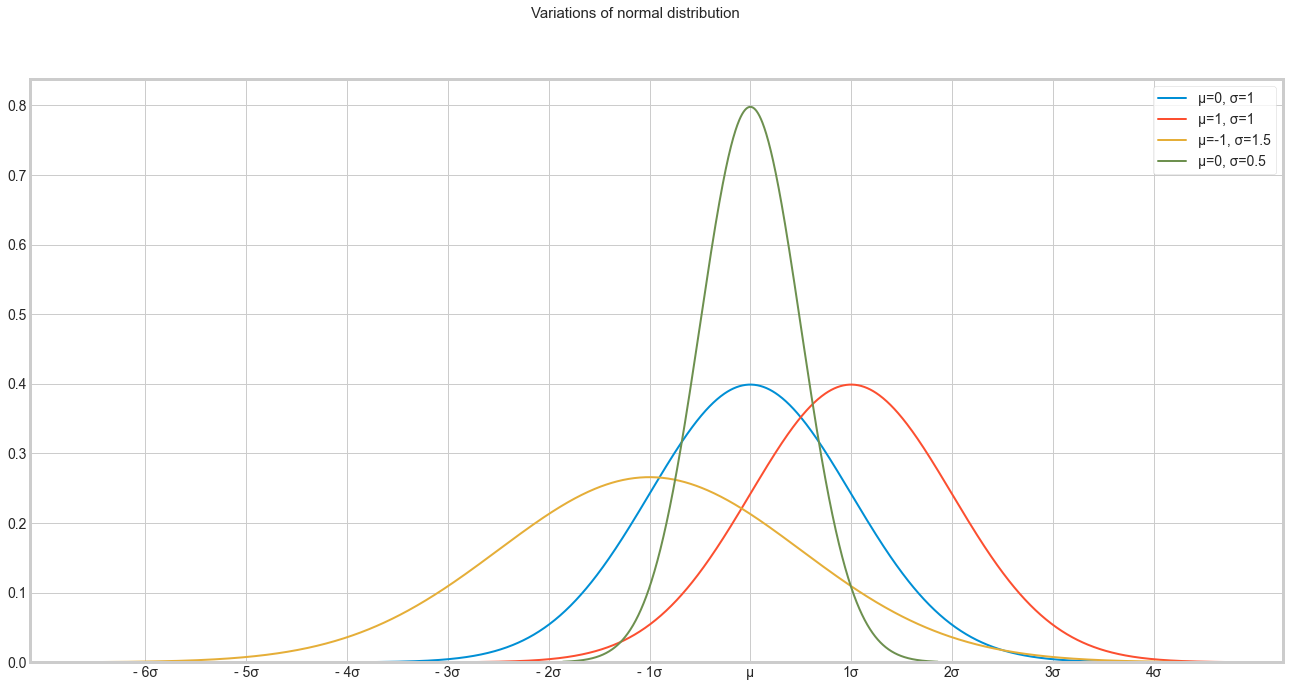

In [242]:
# TODO: refactor
fig, ax = plt.subplots(figsize=(20, 10))

norm_class = namedtuple("norm_dist_parameters", ["loc", "scale"])


@dataclass
class NormParams:
    loc: float
    scale: float

    def __str__(self) -> str:
        return f"μ={self.loc}, σ={self.scale}"


norm_list = [
    NormParams(0, 1),
    NormParams(1, 1),
    NormParams(-1, 1.5),
    NormParams(0, 0.5),
]

fig.suptitle("Variations of normal distribution", fontsize=15)
for norm_params in norm_list:
    norm_rv = stats.norm(loc=norm_params.loc, scale=norm_params.scale)
    x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 1_000)
    ax.plot(x, norm_rv.pdf(x), lw=2, label=norm_params)

x_locations = range(-6, 5)
x_labels = ["- 6σ", "- 5σ", "- 4σ", "- 3σ", "- 2σ", "- 1σ", "μ", "1σ", "2σ", "3σ", "4σ"]
ax.xaxis.set_major_locator(ticker.FixedLocator(x_locations))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
ax.legend()
ax.grid(True)
ax.set_ylim(0)

plt.show()

All of these distributions are normal. They only differ in the offset of the center relative to zero and the scale (some of the are wider, some are narrower). But, each of these distributions continues to obey the probabilistic law, which we talked above. Just as we have expanded, narrowed or shifted our distributions from the norm ($\large\mu$=0 and $\large\sigma$=1), int the opposite way, we can bring any normal distribution to a standard form thanks to the $z$-value.

# 2. $Z$-values

Imaging that after a year our new neighbor decided to order pizza every day. After three days we see how this neighbor accuses the delivery guy of waiting for too long for the order. We tried to support the delivery guy and said that the average delivery time is 30 $\pm$ 5 minutes, to which our neighbor replied that all three times he waited for more than 40 minutes, and this is definitely more than 35 minutes.

Why is our neighbor so sure that the delivery time is too long? It looks like he, like some people, thinks that 30 $\pm$ 5 minutes means that delivery can take 27, 31 or even 35 minutes, but not 23 or 38 minutes. We have ordered pizza 365 times and know that delivery can take somewhere in between 13 and 49 minutes. And the phrase 30 $\pm$ 5 minutes only means that some significant portion of deliveries takes from 25 to 35 minutes. 

Knowing the distribution parameters, we can even simulate 1k deliveries and estimate the size of this part:

In [59]:
N = 5_000
t_data = pizza_delivery_norm_rv.rvs(N, random_state=RANDOM_STATE)
t_data[(25 < t_data) & (t_data < 35)].size / N

0.6874

Approximately two thirds of all generated values are in range from 25 to 35 minutes. How many deliveries took more than 40 minutes?  

In [60]:
t_data[t_data > 40].size / N

0.0224

It turns out that slightly more than 2 percent of generated values took more than 40 minutes. But our neighbor said that he ordered 3 pizzas in a row and all of them took more than 40 minutes. Maybe our neighbor is extremely unlucky because probability of it is very low: 

In [69]:
format(0.02**3, "f")

'0.000008'

Of course computer modeling is all good but in this case it's better to use $Z$-values:

$$ Z = \frac{y - \mu}{\sigma} $$

where:
- $y$: delivery time, i.e. some exact value from random variable $Y$
- $\mu$: mathematical expectation
- $\sigma$: standard deviation

$Z$-value for 40 minutes delivery will be:

$$ Z = \frac{40 - 30}{5} = 2$$

In the numerator we calculated how much our delivery time differs from the average delivery time and then simply divided this value by the standard deviation of the delivery time. But how to interpret this result and why even use the $Z$-value?

In order to understand it we need to "draw" a little bit.

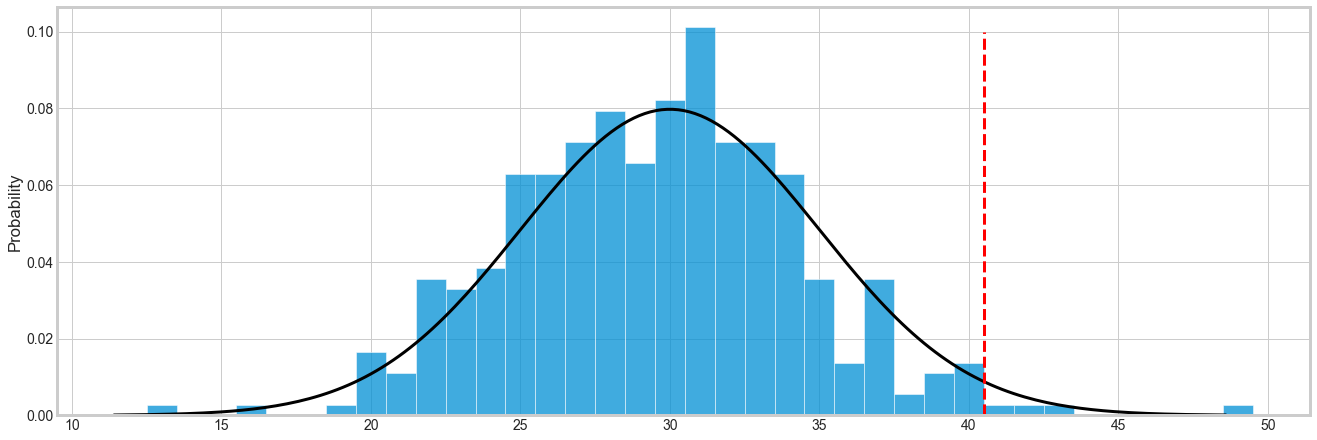

In [259]:
fig, ax = plt.subplots()
x = np.linspace(pizza_delivery_norm_rv.ppf(0.0001), pizza_delivery_norm_rv.ppf(0.9999), 200)
sns.lineplot(x=x, y=pizza_delivery_norm_rv.pdf(x), color="black", lw=3)
sns.histplot(x=pizza_delivery_times, stat="probability", discrete=True)
ax.vlines(40.5, 0, 0.1, color="red", lw=3, linestyles="dashed")

plt.show()

In this chart we plotted a histogram of our samples data, but now the height of each rectangle shows not the number of occurrences of each value in the sample, but the probability of their occurrence in the sample. With the black line we have drawn the probability density function of the distribution of the delivery times. 

Before we tried to experimentally determine what portion of pizza delivery measurements are more than 40 minutes. This chart should give us some ideas that there are two ways of solving this task. The first one is experimental, i.e. we simulate 5k deliveries, build histogram and find the sum of the height of the rectangles located to the right of the red line:

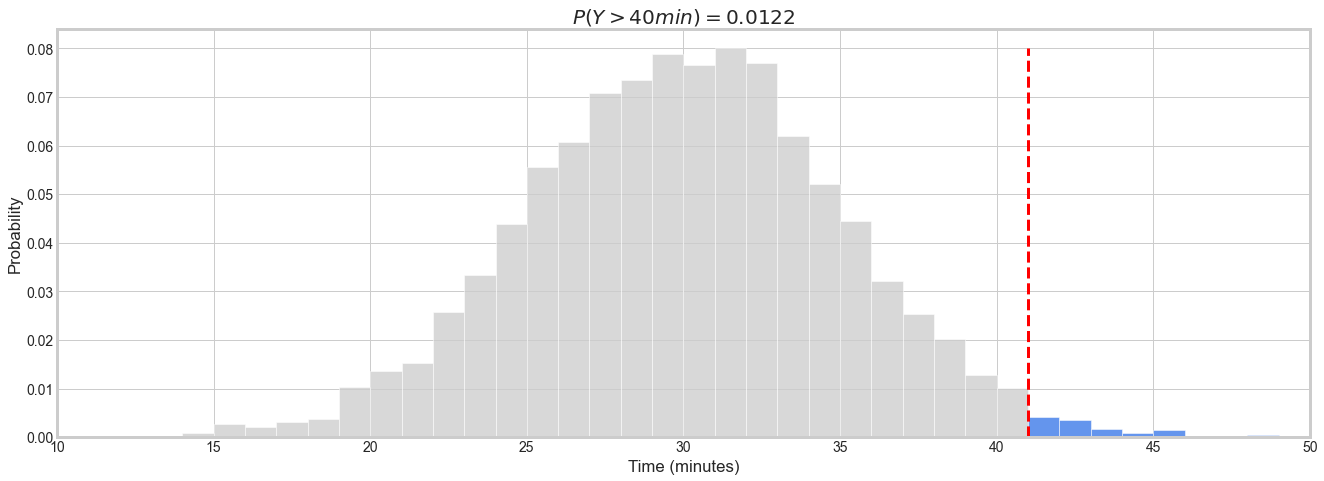

In [346]:
N = 5_000

values = pizza_delivery_norm_rv.rvs(N, random_state=RANDOM_STATE).astype(int)

# create and plot histogram for every minute in range from 0 to 50
ax = sns.histplot(values, bins=np.arange(0, 50), color="0.8", stat="probability")

# probability of delivery time equal or higher than 40 minutes is a sum of
# rectangle heights which represents probability value
p = sum(patch.get_height() for patch in ax.patches[41:])
ax.set_title("$P(Y>40min) = {:.3}$".format(p))
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Probability")
ax.set_xlim([10, 50])
for patch in ax.patches[41:]:
    patch.set_facecolor("cornflowerblue")
y_max = max(patch.get_height() for patch in ax.patches)
ax.vlines(41, 0, y_max, "r", lw=3, linestyles="dashed")

plt.show()

The other approach is analytical. Since we know that the pizza delivery measurements come from a normal distribution, we can use the probability density function of the normal distribution.
The area underneath this function is always equal to 1, so if we are interested in the probability of obtaining the value (in this case 40 minutes), then it is enough to find the area under the function that is to the right of this value.

For example, to calculate and display the probability that the delivery time will be more than 40 minutes, you can do this:

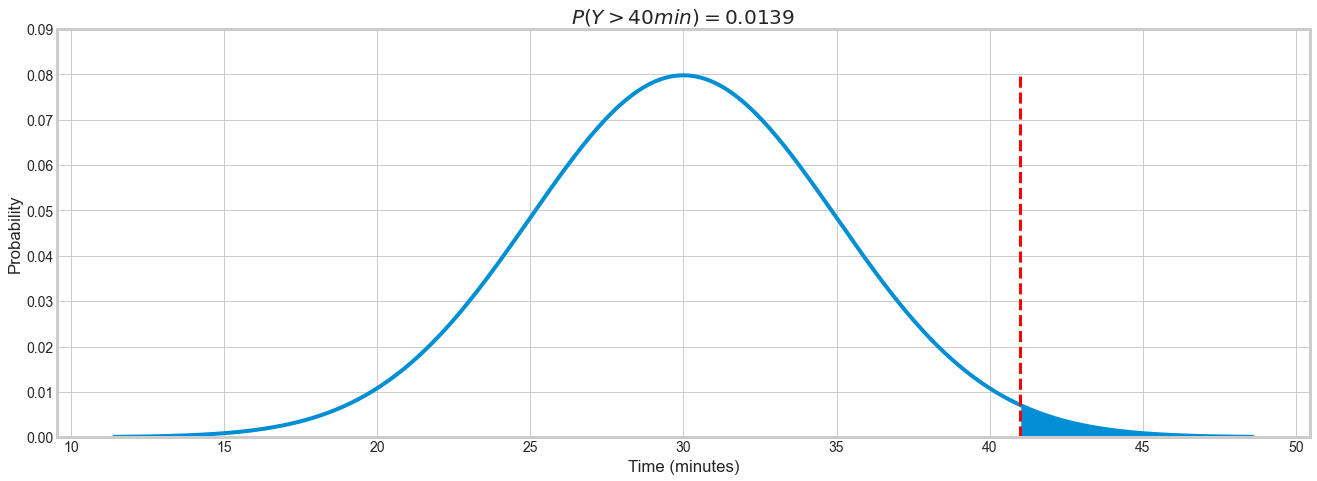

In [319]:
x = np.linspace(pizza_delivery_norm_rv.ppf(0.0001), pizza_delivery_norm_rv.ppf(0.9999), 300)

fig, ax = plt.subplots()

p = 1 - pizza_delivery_norm_rv.cdf(41)
ax.set_title("$P(Y>40min) = {:.3}$".format(p))
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Probability")
ax.set_ylim(0, 0.09)

ax.plot(x, pizza_delivery_norm_rv.pdf(x))
ax.vlines(41, 0, 0.08, color="red", lw=3, linestyles="dashed")
fill_area = x[x > 41]
ax.fill_between(fill_area, pizza_delivery_norm_rv.pdf(fill_area), np.zeros_like(fill_area))

plt.show()

## 2.1. Typicality

Now let's imaging that we find ourselves in Middle-earth and somehow found out that the growth of hobbits and gnomes in centimeters are distributed as $N(91;8^2)$ and $N(134;6^2)$. If Frodo's height is 99 centimeters and Gimli's height is 143 centimeters, then how to understand whose height is more typical among their kinds? To find out, we can plot the probability density function for each population with heights and determine the proportion of those who exceed these values:

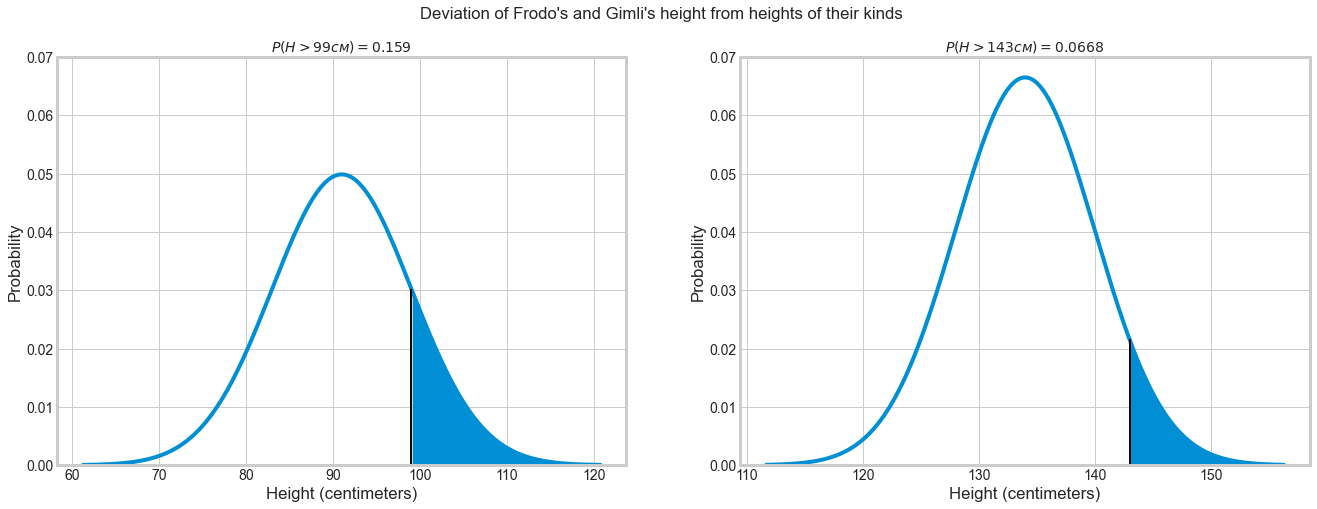

In [276]:
nrv_hobbit = stats.norm(91, 8)
nrv_gnome = stats.norm(134, 6)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes = axes.flatten()
fig.suptitle("Deviation of Frodo's and Gimli's height from heights of their kinds")

for ax, distribution, height in zip(axes, (nrv_hobbit, nrv_gnome), (99, 143)):

    prob = 1 - distribution.cdf(height)
    ax.set_title(f"$P(H > {height} см) = {prob:.3}$", fontdict={"size": 14})
    ax.set_xlabel("Height (centimeters)")
    ax.set_ylabel("Probability")
    ax.set_ylim(0, 0.07)

    x = np.linspace(distribution.ppf(0.0001), distribution.ppf(0.9999), 300)
    ax.plot(x, distribution.pdf(x))
    fill_cond = x[x > height]
    ax.fill_between(fill_cond, distribution.pdf(fill_cond), np.zeros_like(fill_cond))
    ax.vlines(height, 0, distribution.pdf(height), color="k", lw=2)

plt.show()

By looking at these charts we can assume that Frodo's height is more typical than Gimli's as it is closer to the pick of the distribution. That means that it's more likely to find a hobbit with height the same as Frodo than to meat a gnome with height the same as Gimli. That is what `typicality` means.

Performing typicality comparison is much easier if to use $Z$-values:

$$ Z_{Frodo} = \frac{99 - 91}{8} = 1 $$
$$ Z_{Gimli} = \frac{143 - 134}{6} = 1.5 $$

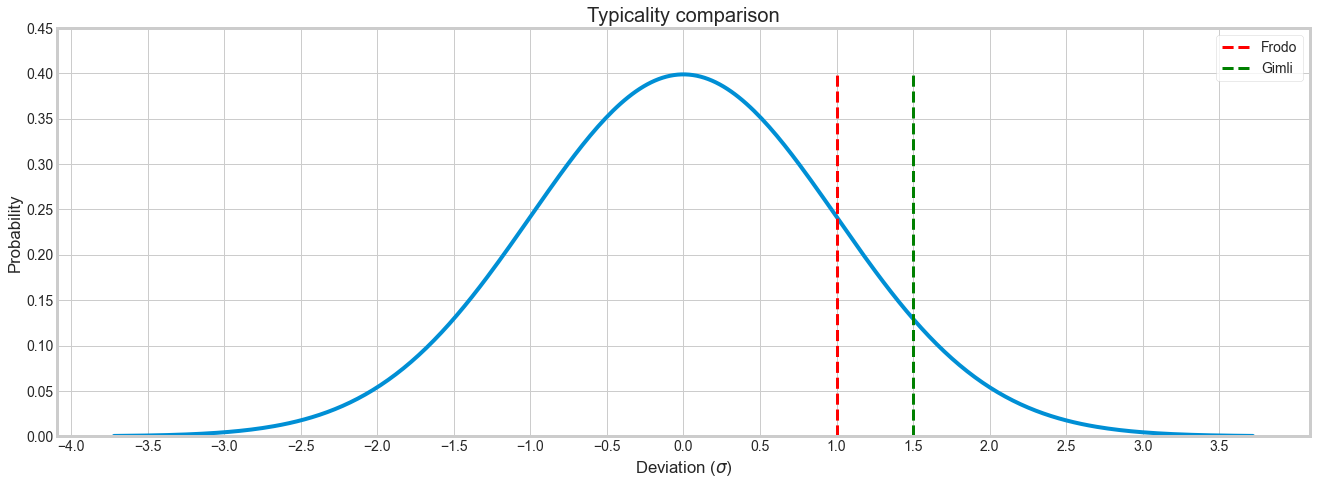

In [295]:
norm_rv = stats.norm(loc=0, scale=1)
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 300)

plt.title("Typicality comparison")
plt.xlabel("Deviation ($\sigma$)")
plt.ylabel("Probability")
plt.ylim(0, 0.45)

plt.plot(x, norm_rv.pdf(x))
plt.vlines(1, 0, 0.4, color="r", lw=3, label="Frodo", linestyles="dashed")
plt.vlines(1.5, 0, 0.4, color="g", lw=3, label="Gimli", linestyles="dashed")
plt.xticks(np.arange(-4, 4, 0.5))
plt.legend()

plt.show()

The great advantage of $Z$-values is that they are standardized, in other words they are transformed in such way like if they were taken from normal distribution $N(0;1)$, both have mean of 0 and std of 1, that's why we were able to plot them at the same chart. 

Even without plotting a chart we can find out which height is more typical by comparing absolute values:

$$ | Z_{Frodo} | < | Z_{Gimli} | $$

values with smaller absolute $Z$-value are more typical.

Comparison of multiple $Z$-values from multiple normal distributions is possible because $Z$-values are measured in $\sigma$ units. It becomes apparent when we take a look at the formula one more time:

$$ Z = \frac{y - \mu}{\sigma} $$

It doesn't matter what we are trying to compare: height, weight or income; whatever original units are, after calculating $Z$-values they are all will be measured in $\sigma$ units. The smaller absolute $Z$-value is, the closer it is to the peak of the distribution (more typical) and the sign of $Z$-value shows to what side of this peak this value is located. 

# 3. $Z$-statistics

Let's go back to our neighbor that is very upset by long time delivery of pizza. Above we calculated $Z$-value for 40 minutes delivery:

$$ Z = \frac{40 - 30}{5} = 2 $$

Right now we don't have enough experience do figure out is it a lot or not so let's draw a chart first:

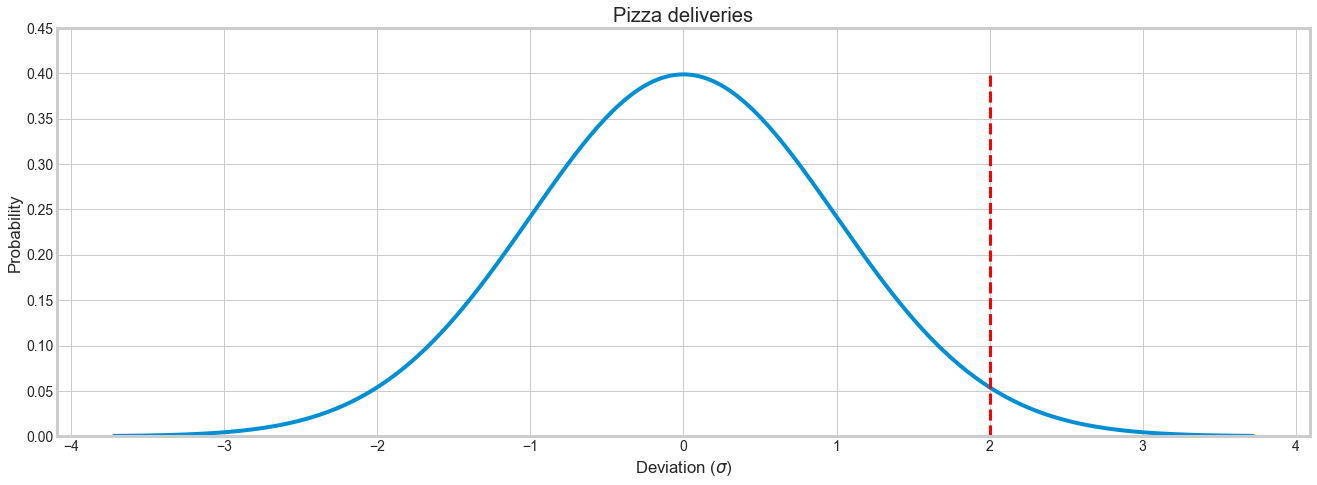

In [305]:
norm_rv = stats.norm(loc=0, scale=1)
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 300)

plt.title("Pizza deliveries")
plt.xlabel("Deviation ($\sigma$)")
plt.ylabel("Probability")
plt.ylim(0, 0.45)

plt.plot(x, norm_rv.pdf(x))
plt.vlines(2, 0, 0.4, color="red", lw=3, linestyles="dashed")

plt.show()

This value is in $2\sigma$ distance away from peak of the distribution which is quite a lot actually. However our neighbor claims that he have been weighting for 40 minutes 3 times in a row. He may not have calculated the average wait time for his pizzas, but three number is a statistics!

Characteristics of the general population are called _parameters_ and characteristics of a sample - _statistics_. By measuring delivery time during 365 days we made a conclusion about parameters of the general distribution, in other words about all possible delivery times, deciding that those values are taken from normal distribution with parameters $N(30;5^2)$. By knowing that we can make some experiments. For example our neighbor made only three orders and according to him all three took more than 40 minutes. What if we repeat this experiment 5k times and take a look at the distribution of averages of 3 orders:

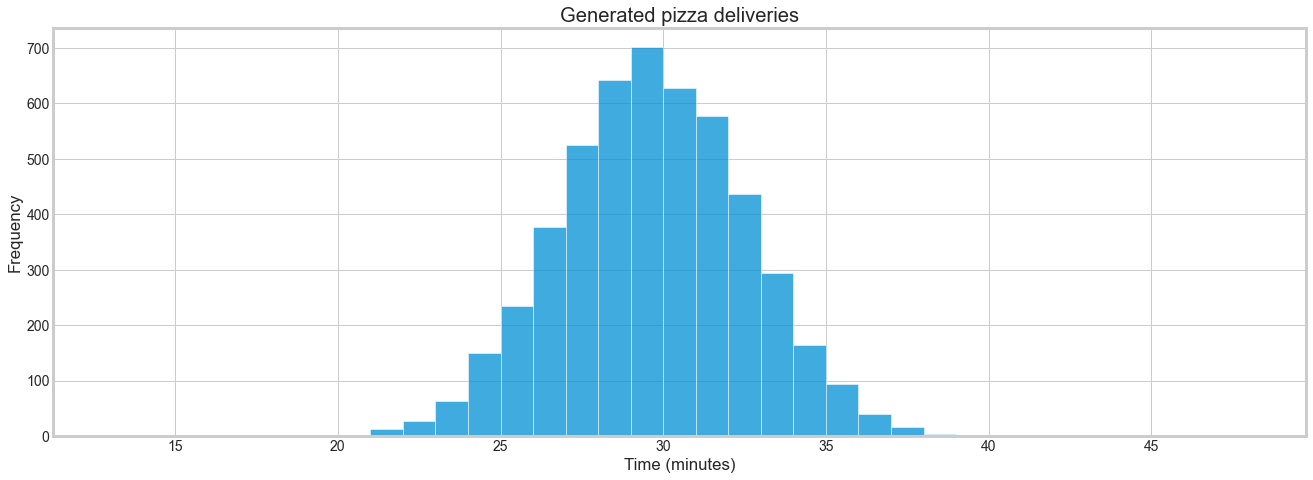

In [307]:
np.random.seed(RANDOM_STATE)
N = 5_000
neighbor_delivery_averages = pizza_delivery_norm_rv.rvs(size=(N, 3)).astype(int).mean(axis=1)

plt.title("Generated pizza deliveries")
plt.xlabel("Time (minutes)")
plt.ylabel("Frequency")

sns.histplot(neighbor_delivery_averages, bins=np.arange(13, 49))

plt.show()

Judging by the chart we can see that to get an average delivery time more than 40 minutes is very unlikely, almost impossible. 

We can have two explanations:
- Either our neighbor is not telling a truth.
- Or something is wrong with the general population, i.e. perhaps for some reason delivery is changed and now it takes more time then before.

Measured $Z$-value for 40 minutes delivery ($Z$ = 2) allows us to calculate probability to get values more than 40: 

In [308]:
prob = 1 - norm_rv.cdf(2)
prob

0.02275013194817921

That's why it's unsurprising that probability of getting an average time of 3 deliveries more than 40 minutes is extremely low:

In [309]:
format(prob**3, "f")

'0.000012'

If we can evaluate each individual value of the delivery time using a $Z$-value, then in order to estimate the probability of the arithmetic mean of these values, we need to use the $Z$-statistics:

$$ Z = \frac{\bar{x} - \mu}{\frac{\sigma}{\sqrt{n}}} $$

where:
- $\bar{x}$: mean of the sample
- $\mu$: mean value of general population
- $\sigma$: standard deviation of general population
- $n$: size of the sample

Let's assume that we made three orders and the average value turned out to be 35 minutes, then the $Z$-statistics will be calculated as follows:

$$ Z = \frac{35-30}{\frac{5}{\sqrt{3}}} \approx 1.73 $$

$Z$-statistics, as like $Z$-value, is measured in units of standard deviation and it lets us to use standard normal distribution for calculation of probabilities. In fact we are trying to ask a question: what is the probability of the average of three deliveries to be in range:

$$ \left[ \mu - | \mu - \bar{x} |; \mu + | \mu - \bar{x} | \right] $$

which is in our case looks like $\left[25;35\right]$ minutes.

As before, we can find this probability using simulation:

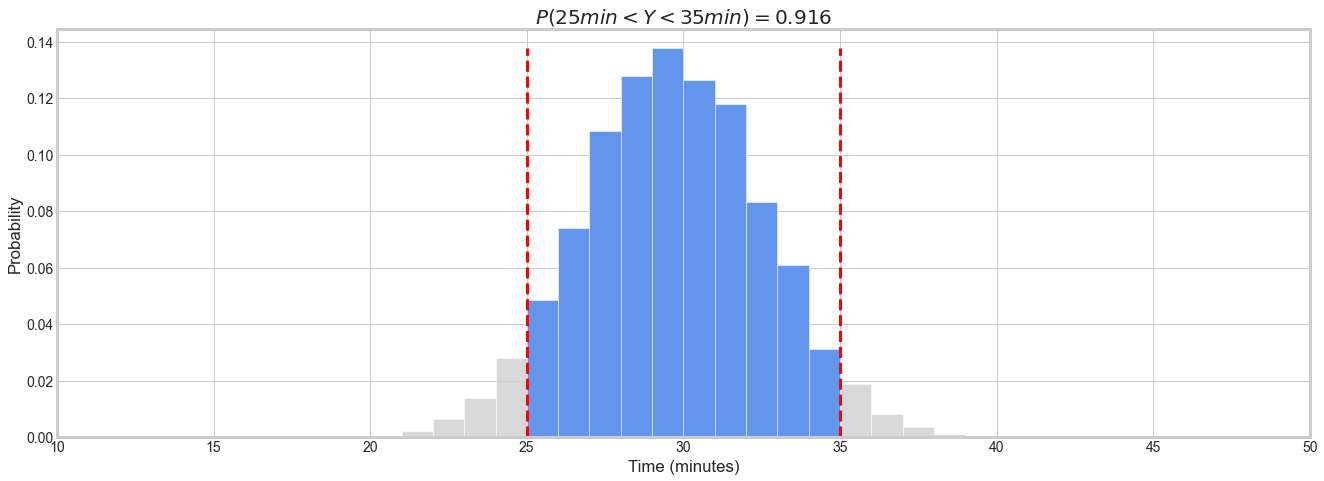

In [345]:
N = 10_000
means = pizza_delivery_norm_rv.rvs(size=(N, 3), random_state=RANDOM_STATE).astype(int).mean(axis=1)

ax = sns.histplot(means, bins=np.arange(0, 50), color="0.8", stat="probability")

prob = sum(patch.get_height() for patch in ax.patches[25:35])
ax.set_title(f"$P(25min < Y < 35min) = {prob:.3f}$")
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Probability")
ax.set_xlim([10, 50])
for patch in ax.patches[25:35]:
    patch.set_facecolor("cornflowerblue")
y_max = max(patch.get_height() for patch in ax.patches)
ax.vlines(25, 0, y_max, "r", lw=3, linestyles="dashed")
ax.vlines(35, 0, y_max, "r", lw=3, linestyles="dashed")

plt.show()

On the other hand, we can calculate the same probability in a analytical way:

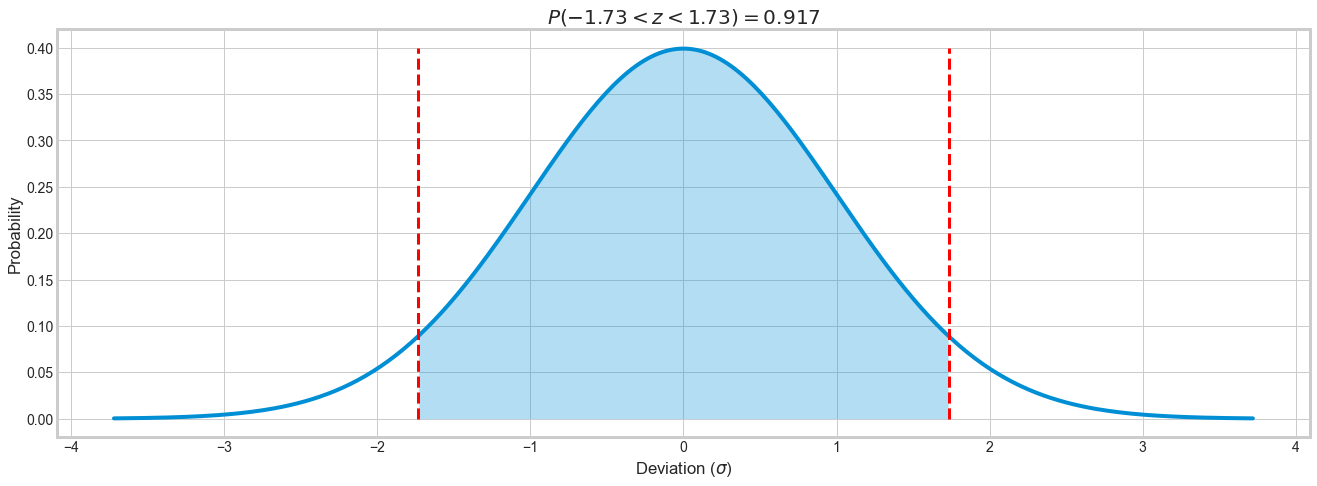

In [369]:
x_bar, n, mu, sigma = 35, 3, 30, 5
z = abs((x_bar - mu) / (sigma / n**0.5))
norm_rv = stats.norm(loc=0, scale=1)
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 300)

fig, ax = plt.subplots()

prob = norm_rv.cdf(z) - norm_rv.cdf(-z)
ax.set_title(f"$P({-z:.3} < z < {z:.3}) = {prob:.3}$")
ax.set_xlabel("Deviation ($\sigma$)")
ax.set_ylabel("Probability")

ax.plot(x, norm_rv.pdf(x))
ax.vlines([-z, z], 0, 0.4, color="red", lw=3, linestyles="dashed")
fill_cond = x[(x > -z) & (x < z)]
ax.fill_between(fill_cond, norm_rv.pdf(fill_cond), np.zeros_like(fill_cond), alpha=0.3)

plt.show()

Note that $Z$-statistics depends not only on sample mean $\bar{x}$ but also on it's size $n$. If we order pizza 5, 30 or even 100 times, then what is the probability that the average delivery time will be in range $\left[29;31\right]$? Let's take a look:

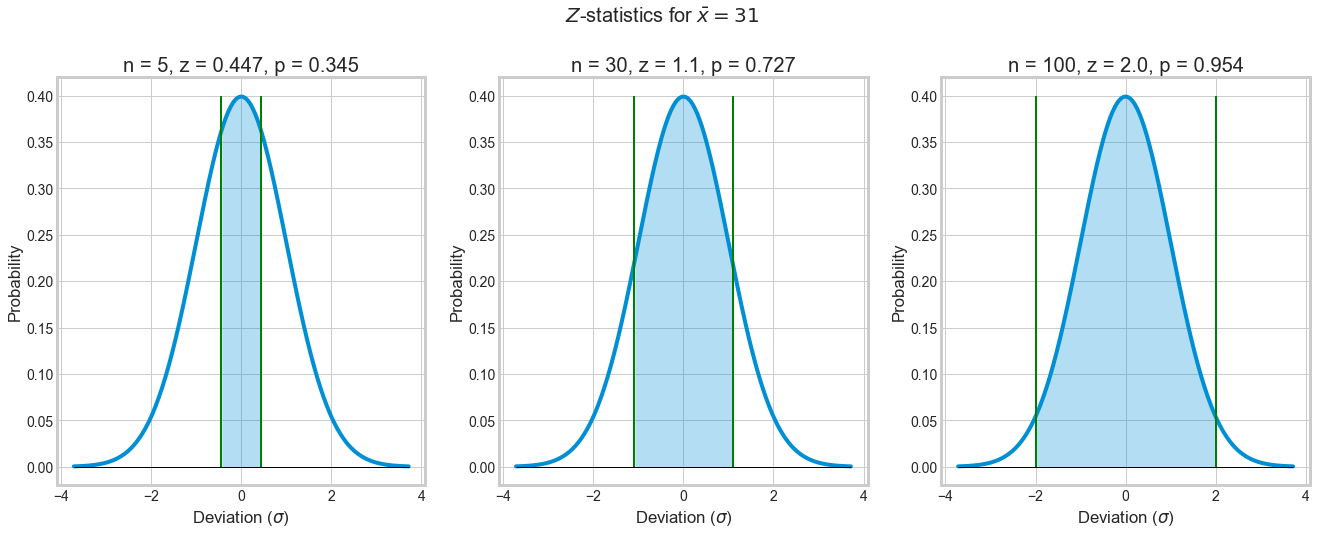

In [368]:
fig, ax = plt.subplots(nrows=1, ncols=3)

for i, n in enumerate([5, 30, 100]):
    x, mu, sigma = 31, 30, 5
    z = abs((x - mu) / (sigma / n**0.5))

    N_rv = stats.norm()
    x = np.linspace(N_rv.ppf(0.0001), N_rv.ppf(0.9999), 300)
    ax[i].plot(x, N_rv.pdf(x))
    ax[i].hlines(0, x.min(), x.max(), lw=1, color="k")
    ax[i].vlines([-z, z], 0, 0.4, color="g", lw=2)
    x_z = x[(x > -z) & (x < z)]  # & (x<z)
    ax[i].fill_between(x_z, N_rv.pdf(x_z), np.zeros(len(x_z)), alpha=0.3)

    p = N_rv.cdf(z) - N_rv.cdf(-z)
    ax[i].set_title("n = {}, z = {:.3}, p = {:.3}".format(n, z, p))
    ax[i].set_xlabel("Deviation ($\sigma$)")
    ax[i].set_ylabel("Probability")
fig.suptitle(r"$Z$-statistics for $\bar{x} = 31$", fontsize=20, y=1.02)
plt.show()

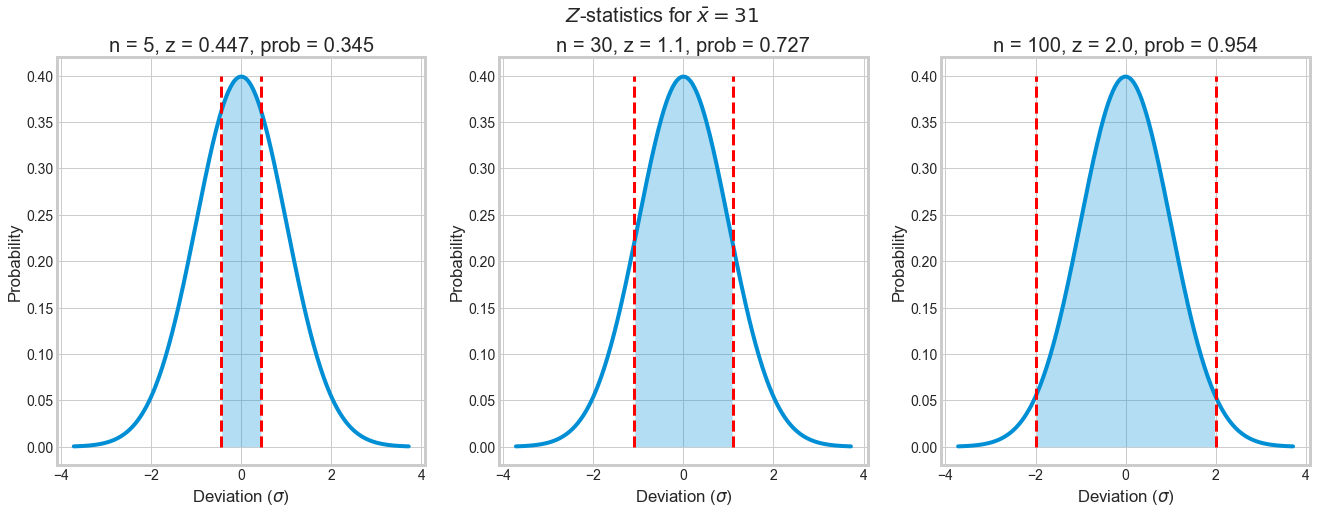

In [375]:
x_bar, mu, sigma = 31, 30, 5
norm_rv = stats.norm(loc=0, scale=1)
x = np.linspace(norm_rv.ppf(0.0001), norm_rv.ppf(0.9999), 300)

fig, axes = plt.subplots(nrows=1, ncols=3)
fig.suptitle(r"$Z$-statistics for $\bar{x} = 31$", fontsize=20)
axes = axes.flatten()

for ax, n in zip(axes, [5, 30, 100]):

    z = abs((x_bar - mu) / (sigma / n**0.5))
    prob = norm_rv.cdf(z) - norm_rv.cdf(-z)
    ax.set_title(f"n = {n}, z = {z:.3}, prob = {prob:.3}")
    ax.set_xlabel("Deviation ($\sigma$)")
    ax.set_ylabel("Probability")

    ax.plot(x, norm_rv.pdf(x))
    ax.vlines([-z, z], 0, 0.4, color="red", lw=3, linestyles="dashed")
    fill_cond = x[(x > -z) & (x < z)]
    ax.fill_between(fill_cond, norm_rv.pdf(fill_cond), np.zeros_like(fill_cond), alpha=0.3)

plt.show()

With 5 orders the sample mean will be in range $\left[29;31\right]$ rather by chance than systematically. With 30 orders about a quarter of averages will not be in the range. And only with 100 orders we can be more or less sure that deviation of the sample mean from general population mean will not be more than 1 minute.

On the other hand we can think about it in another way: if the general population mean is equal to 30 minutes, what is the probability of getting sample mean if we make 5, 30 or 100 orders? It's obvious that with 5 orders sample mean will deviate quite a lot, therefore the probability of obtaining $\bar{x}$=31 is quite high. But with 100 orders sample mean almost does not deviate from the general population mean, so it is almost impossible to randomly obtain $\bar{x}$ with $n$=100. 

What does it mean? It means that if we order 100 pizzas and get sample mean of 31 minutes, then most likely we are wrong that the general population mean is equal to 30 minutes.

What to do with our neighbor that ordered only 3 pizzas? Is he right? Looks like it, yes. Even if his average delivery time is 40 minutes, $Z$-statistics would be 3.81 and the area under the curve will be almost equal to 1:

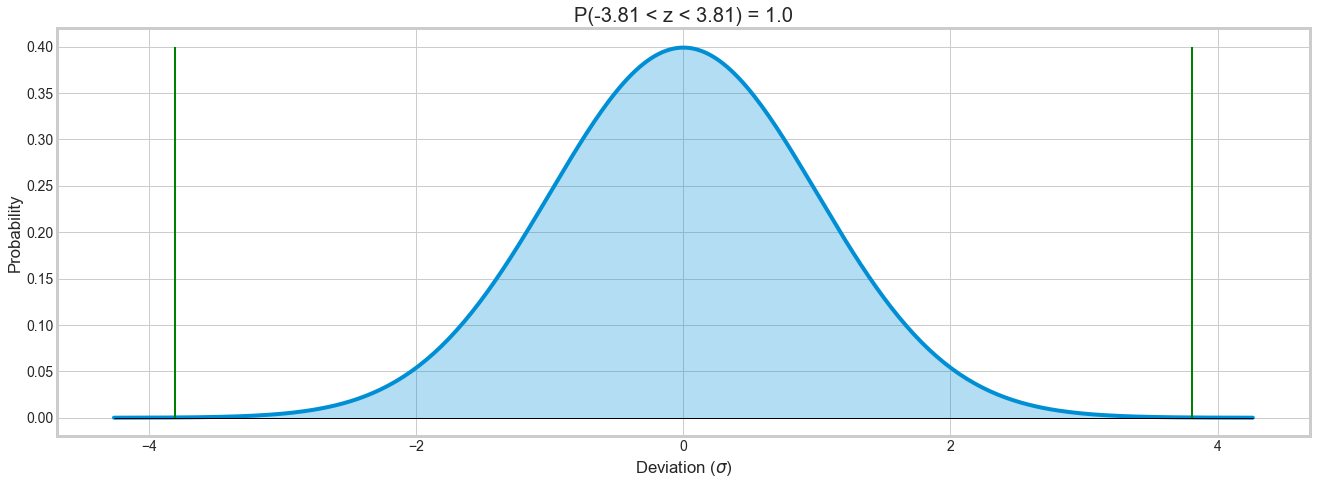

In [376]:
x, n, mu, sigma = 41, 3, 30, 5
z = abs((x - mu) / (sigma / 3**0.5))

N_rv = stats.norm()
fig, ax = plt.subplots()
x = np.linspace(N_rv.ppf(1e-5), N_rv.ppf(1 - 1e-5), 300)
ax.plot(x, N_rv.pdf(x))
ax.hlines(0, x.min(), x.max(), lw=1, color="k")
ax.vlines([-z, z], 0, 0.4, color="g", lw=2)
x_z = x[(x > -z) & (x < z)]  # & (x<z)
ax.fill_between(x_z, N_rv.pdf(x_z), np.zeros(len(x_z)), alpha=0.3)

p = N_rv.cdf(z) - N_rv.cdf(-z)
ax.set_title("P({:.3} < z < {:.3}) = {:.3}".format(-z, z, p))
ax.set_xlabel("Deviation ($\sigma$)")
ax.set_ylabel("Probability")
plt.show()

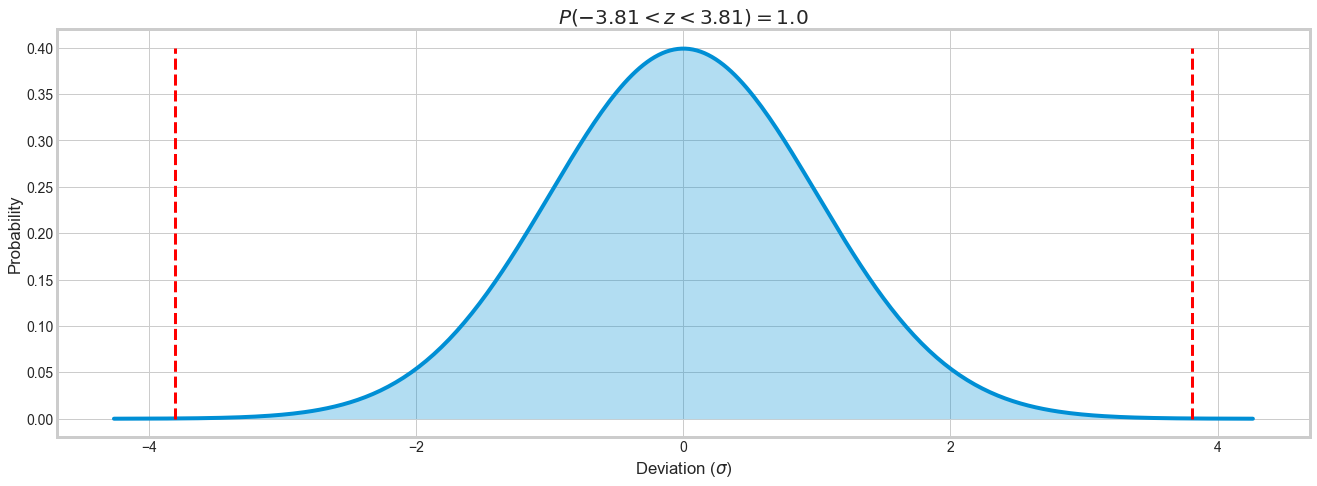

In [378]:
x_bar, n, mu, sigma = 41, 3, 30, 5
z = abs((x_bar - mu) / (sigma / 3**0.5))
norm_rv = stats.norm()
x = np.linspace(norm_rv.ppf(0.00001), norm_rv.ppf(0.99999), 300)

fig, ax = plt.subplots()

prob = norm_rv.cdf(z) - norm_rv.cdf(-z)
ax.set_title(f"$P({-z:.3} < z < {z:.3}) = {prob:.3}$")
ax.set_xlabel("Deviation ($\sigma$)")
ax.set_ylabel("Probability")

ax.plot(x, norm_rv.pdf(x))
ax.vlines([-z, z], 0, 0.4, color="red", lw=3, linestyles="dashed")
fill_cond = x[(x > -z) & (x < z)]
ax.fill_between(fill_cond, norm_rv.pdf(fill_cond), np.zeros_like(fill_cond), alpha=0.3)

plt.show()

That means that probability of obtaining random variable that deviates from general distribution with $\mu$=30 and $\sigma$=5 by more than 10 minutes is extremely low. In this case we can assume that:
- either our neighbor is very unlucky person
- or pizza delivery is changed and now take more time then before

What of the above is more likely? Most likely our neighbor is right about long delivery time.

# 4. $P$-value

We saw that $Z$-statistics gives us possibility to measure probability of sample mean $\bar{x}$ with size $n$ that is taken from general population to be within given range. That allows us to make a conclusion of how random $\bar{x}$ is. The smaller the absolute value of the $Z$-statistics the lower the reliability of the mean.

For example, previously we saw that probability of $\bar{x}$ with $n$=5 to be in range $\left[29;31\right]$ is only about 0.35, while probability of not being in that range is $1-0.35=0.65$. That's why we've made conclusion that $\bar{x}$=31 of at $n$=5 is due to chance rather than to any objective reason. 

In fact value of 0.65, that we've obtained earlier, is called $p$-value and it shows the probability of accidentally fall beyond the boundaries of the interval specified by the value of the $Z$-statistics, which can be depicted as follows:

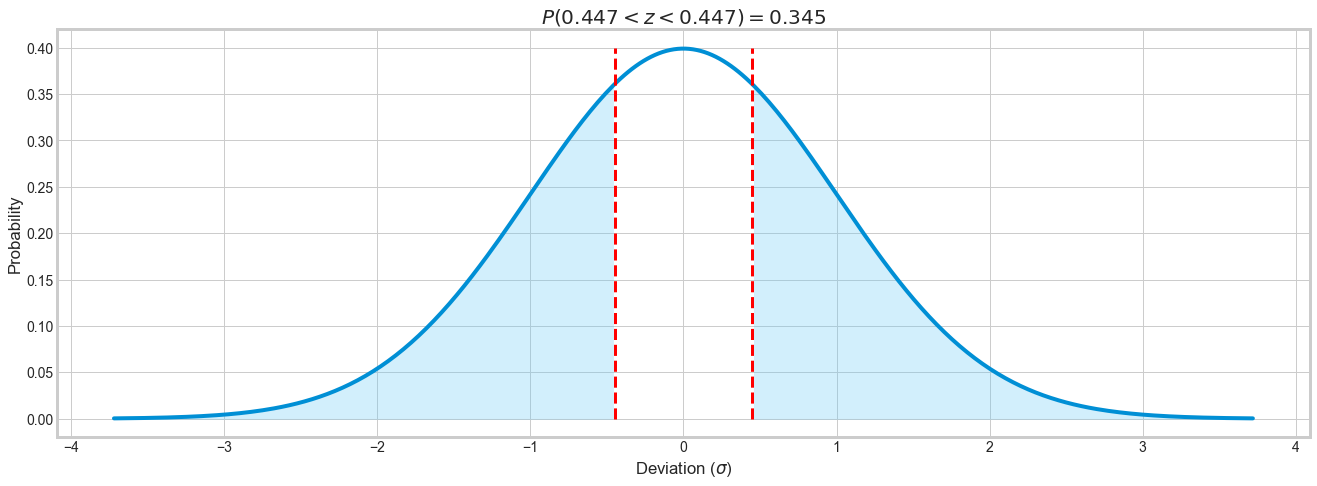

In [401]:
x_bar, n, mu, sigma = 31, 5, 30, 5
z = abs((x_bar - mu) / (sigma / n**0.5))
norm_rv = stats.norm(loc=0, scale=1)
x = np.linspace(N_rv.ppf(0.0001), N_rv.ppf(0.9999), 300)

prob = norm_rv.cdf(z) - norm_rv.cdf(-z)
plt.title(f"$P({z:.3} < z < {z:.3}) = {prob:.3}$")
plt.xlabel("Deviation ($\sigma$)")
plt.ylabel("Probability")

plt.plot(x, norm_rv.pdf(x))
plt.vlines([-z, z], 0, 0.4, color="red", lw=3, linestyles="dashed")
fill_cond_left, fill_cond_right = x[x < -z], x[x > z]
plt.fill_between(fill_cond_left, norm_rv.pdf(fill_cond_left), np.zeros_like(fill_cond_left), alpha=0.3, color="#6acbf7")
plt.fill_between(
    fill_cond_right, norm_rv.pdf(fill_cond_right), np.zeros_like(fill_cond_right), alpha=0.3, color="#6acbf7"
)

plt.show()

The smaller the $p$-value is the less likely it is that the sample mean was obtained by chance. At the same time, $p$-value is directly related to two-sided hypotheses, i.e. hypotheses about the value falling into a given interval. If we got some results, but the $p$-value turned out to be quite large, then these results can hardly be considered significant. Moreover, traditionally, the significance level, denoted by the letter $\alpha$ is 0.05, which means that to confirm the significance of the results, the $p$-value must be less tha this level.

However, it is worth noting that the traditional level of significance $\alpha$=0.05 may not be suitable in some areas of research. For example, in the field of education, you can certainly get $\alpha$=0.1, while in quantum physics, you will easily have to reduce this level to $\pm5\sigma$, i.e. $\alpha$ will be equal to:

In [402]:
format(1 - (norm_rv.cdf(5) - norm_rv.cdf(-5)), ".10f")

'0.0000005733'

We need to not forget that acceptance score determined not only by the sample mean, but also by it's size. If we get several values that are extremely uncharacteristic of the general population, as in the case of our neighbor, then this is already a reason to be wary. 

For example, our neighbor might have measured delivery time with his clocks, but it's battery might fail and that caused wrong measurements of delivery time. Errors associated with sampling (data collection) are very common. If there are no errors, then for more confidence, it is enough to increase the sample a little bit more. For example, our neighbor could have made two more orders before he started making a fuss.

On the other hand in order to confirm small deviations from the population mean we need to increase size of the sample significantly. If we want to state with a level of significance $\alpha=0.05$ that average pizza delivery time is equal to 31 and not 30 as we previously thought, then we need to make at least 100 orders.

# 5. Wraparound

In [202]:
# TODO: make it better

High $Z$-value is bad, that means that the value is further from peak of the distribution and because of that it is not that typical and probability of getting it is quite low.

High $Z$-statistics value is good, it means that the probability of having sample with such average in giving range. The bigger range it is the better.

$P$-value depends on $Z$-value such as $P-value = 1 - Z-statistics$. The lower $P$-value is the more likely that the sample's average can randomly get out of range. Ideally $P$-value should be less than 0.05 (5%).

# ABBREVIATIONS 

- _rv_: random variable
- _pdf_: probability distribution function
- _cdf_: cumulative distribution function
- _ppf_: percent point function (inverse of cdf — percentiles)
- _rvs_: random variates